# Debug det-sim NB

### JAH 3/12/19

In [1]:
import time

%load_ext autoreload
%autoreload 2

import numpy             as np
import scipy             as sc
import scipy.stats       as st
import tables            as tb

from typing    import Callable
from typing    import Tuple
from typing    import List

import invisible_cities.core    .system_of_units_c as system_of_units
import invisible_cities.core    .fit_functions     as fitf
import invisible_cities.database.load_db           as db

import myhistos         as ht
import detsim           as ds

units = system_of_units.SystemOfUnits()

# Plotting configuration

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 5, 4
plt.rcParams["font.size"]               = 12
plt.rcParams["figure.max_open_warning"] = 100

## DetSim

In [3]:
detsimparams = ds.DetSimParameters()

## Generate - drift - diffuse electrons

total energy  41.50719999999999  keV
name  deposits x (mm) : mean =  -0.6 , std =  0.7999999999999999
name  deposits y (mm) : mean =  -0.5 , std =  0.8850612031567836
name  deposits z (mm) : mean =  299.5 , std =  0.8850612031567836
total energy  41.50719999999999  keV
name  deposits x (mm) : mean =  -0.6 , std =  0.7999999999999999
name  deposits y (mm) : mean =  -0.5 , std =  0.8850612031567836
name  deposits z (mm) : mean =  299.5 , std =  0.8850612031567836
name  deposits energy (eV) : mean =  1383.5733333333335 , std =  2185.4999658252623
number of secondary elctrons  1824
number of drifted electrons  1824
number of diffused electrons  1824
longitudinal diffusion  1.641797795101455
transverse diffusion 5.472659317004851
name  deposits energy (eV) : mean =  1383.5733333333335 , std =  2185.4999658252623
number of secondary elctrons  1824
number of drifted electrons  1824
number of diffused electrons  1824
longitudinal diffusion  1.641797795101455
transverse diffusion 5.472659317004

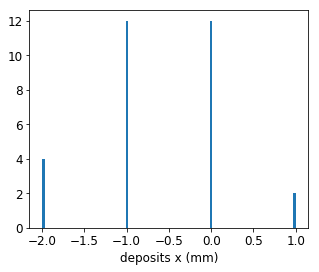

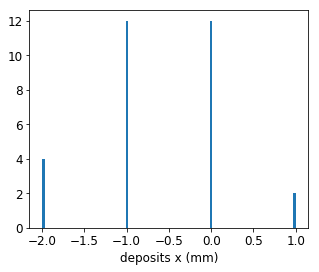

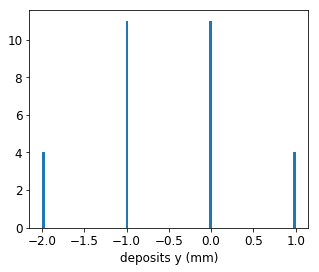

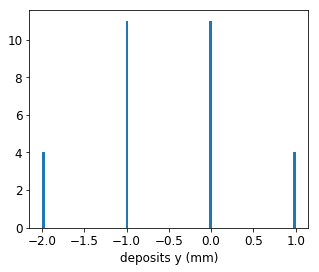

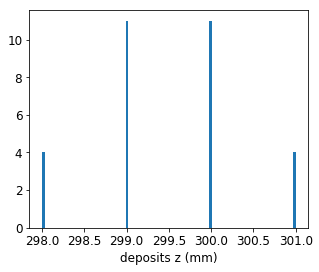

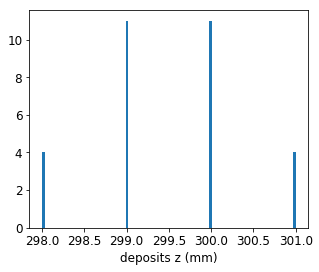

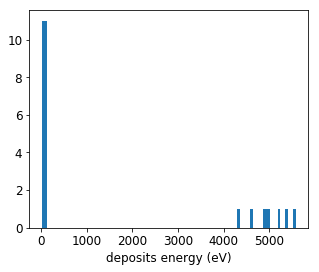

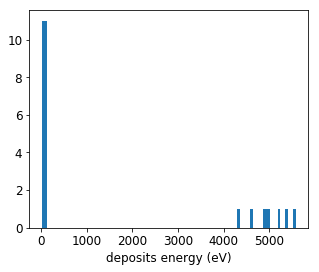

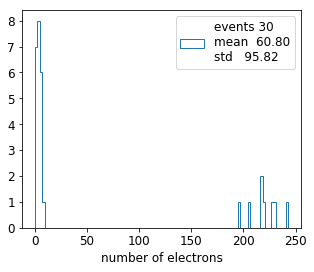

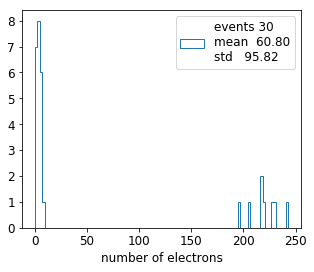

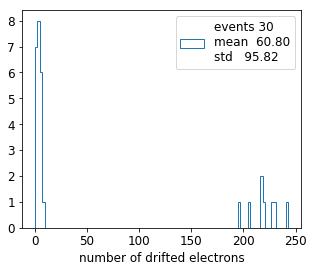

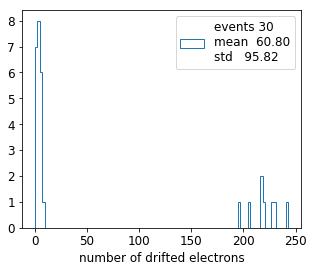

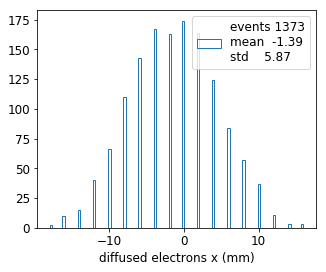

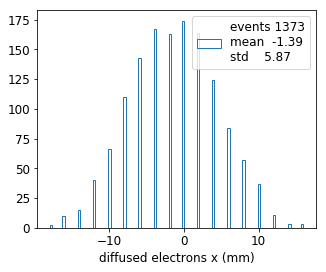

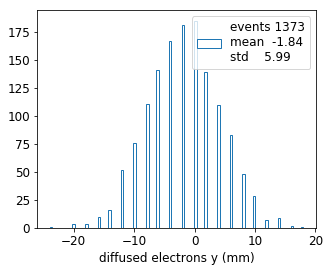

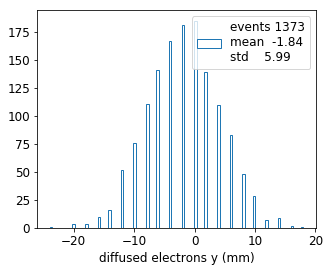

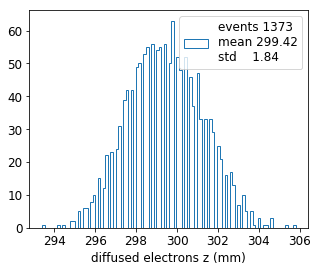

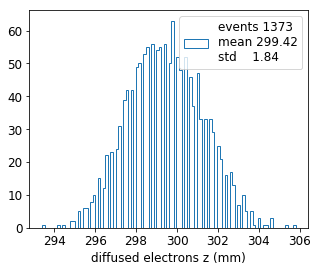

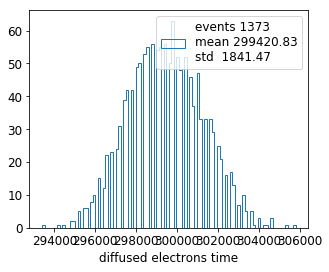

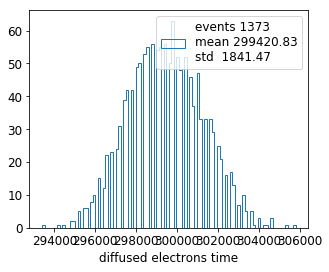

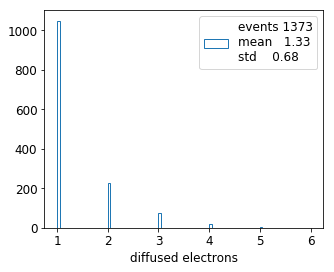

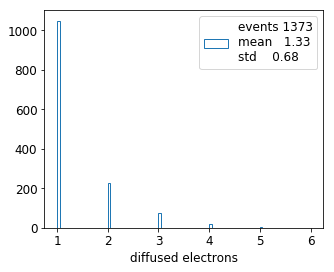

In [4]:
plot = True
# generate deposits
xs, ys, zs, enes = ds.generate_deposits(xsigma = 0.4)
if (plot):
    print('total energy ', np.sum(enes) / units.keV, ' keV')
    ds.histo(xs, 'deposits x (mm)')
    ds.histo(ys, 'deposits y (mm)')
    ds.histo(zs, 'deposits z (mm)')
    ds.histo(enes / units.eV, 'deposits energy (eV)')
    
# generate electrons
nes = ds.generate_electrons(enes)
if (plot):
    print('number of secondary elctrons ', np.sum(nes))
    ht.hist(nes, 100); plt.xlabel('number of electrons')

# drift electrons
nes = ds.drift_electrons(zs, nes)
if (plot):
    print('number of drifted electrons ', np.sum(nes));
    ht.hist(nes, 100); plt.xlabel('number of drifted electrons')

# diffuse electrons
dxs, dys, dzs, dnes = ds.diffuse_electrons(xs, ys, zs, nes)
dts                 = dzs / detsimparams.drift_velocity
if (plot):
    print('number of diffused electrons ', np.sum(nes));
    print('longitudinal diffusion ', detsimparams.longitudinal_diffusion * np.sqrt(np.mean(zs)))
    print('transverse diffusion'   , detsimparams.transverse_diffusion * np.sqrt(np.mean(zs)))
    ht.hist(dxs  , 100); plt.xlabel('diffused electrons x (mm)')
    ht.hist(dys  , 100); plt.xlabel('diffused electrons y (mm)')
    ht.hist(dzs  , 100); plt.xlabel('diffused electrons z (mm)')
    ht.hist(dts  , 100); plt.xlabel('diffused electrons time')
    ht.hist(dnes , 100); plt.xlabel('diffused electrons')

number of EL photons 1824967.3002385523
pes  [18175.06956352 18175.06956352 18175.06956352 18175.06956352
 18175.06956352 18175.06956352 18175.06956352 18175.06956352
 18175.06956352 18175.06956352 18175.06956352 18175.06956352]
number of EL photons 1824967.3002385523
pes  [18175.06956352 18175.06956352 18175.06956352 18175.06956352
 18175.06956352 18175.06956352 18175.06956352 18175.06956352
 18175.06956352 18175.06956352 18175.06956352 18175.06956352]
pes  [0.49344763 0.5285716  0.56610796 ... 0.54334785 0.50777164 0.47445417]
pes  [0.49344763 0.5285716  0.56610796 ... 0.54334785 0.50777164 0.47445417]


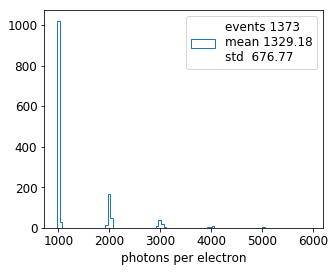

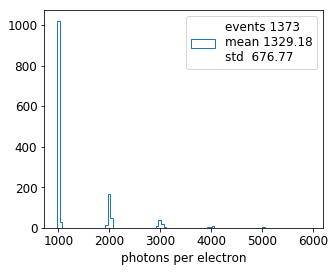

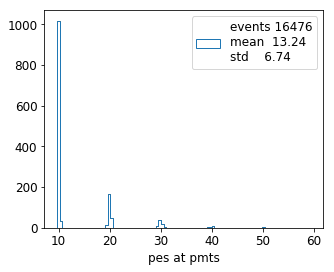

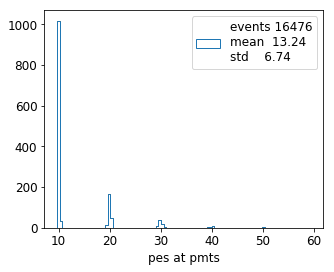

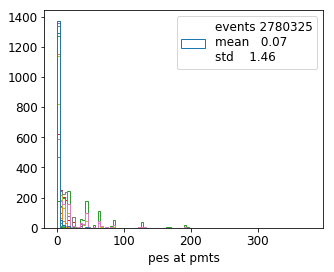

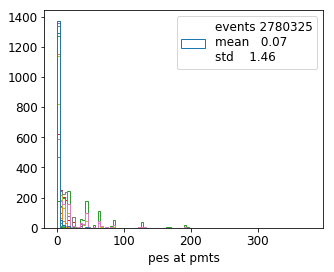

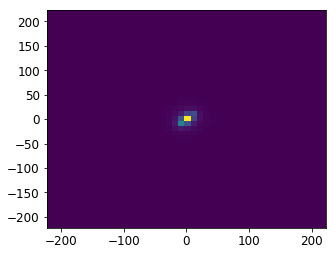

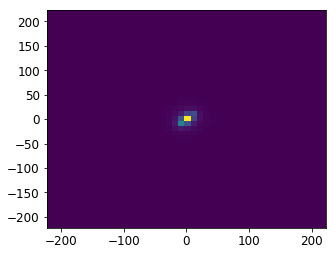

In [5]:
photons = ds.generate_EL_photons(dnes)
if (plot):
    print('number of EL photons', np.sum(photons))
    ht.hist(photons, 100); plt.xlabel('photons per electron');

pes_pmts = ds.estimate_pes_at_pmts(dxs, dys, photons)
if (plot):
    print('pes ', np.sum(pes_pmts, axis = 0))
    ht.hist(pes_pmts, 100); plt.xlabel('pes at pmts')
    
pes_sipms = ds.estimate_pes_at_sipms(dxs, dys, photons)
if (plot):
    print('pes ', np.sum(pes_sipms, axis = 0))
    ht.hist(pes_sipms, 100); plt.xlabel('pes at pmts')
    
    plt.figure();
    int_pes_sipms  = np.sum(pes_sipms, axis = 0)
    plt.hist2d(detsimparams.x_sipms, detsimparams.y_sipms, bins = detsimparams.xybins, weights = int_pes_sipms);

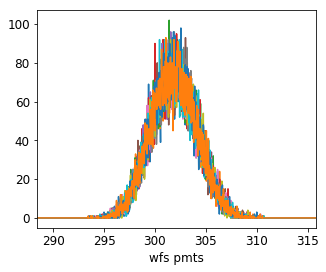

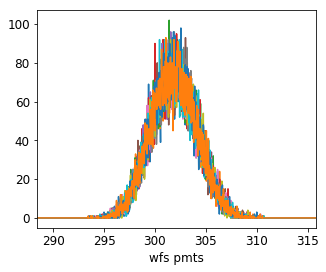

In [7]:
times_pmts, wfs_pmts = ds.create_wfs_pmts(dts, pes_pmts)
#print(times_pmts.shape, wfs_pmts.shape)
if (plot):
    xcenters = times_pmts
    plt.plot(xcenters / units.mus, wfs_pmts); plt.xlabel('wfs pmts')
    plt.xlim((np.min(dts) /units.mus - 5, np.max(dts) / units.mus + 10));

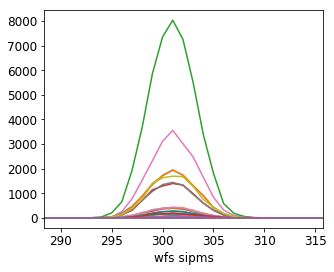

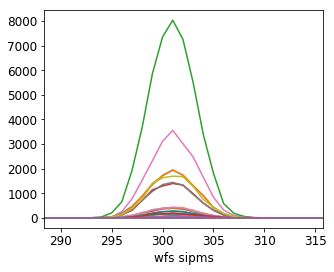

In [8]:
times_sipms, wfs_sipms = ds.create_wfs_sipms(dts, pes_sipms)
if (plot):
    xcenters = times_sipms
    plt.plot(xcenters / units.mus, wfs_sipms); plt.xlabel('wfs sipms')
    plt.xlim((np.min(dts) /units.mus - 5, np.max(dts) / units.mus + 10));

## One go

In [9]:
def simulate_tracks(x0 = 0, y0 = 0, z0 = 300 * units.mm, tx = 0.2, ty = -0.1, 
                    ene = 511 * units.keV, dz = 2 * units.mm):
    
    nsteps = int((ene  - (150 * units.keV)) / (4.4 * units.keV))
    nsteps = max(nsteps , 1)
    xs = x0 + tx * dz * np.arange(nsteps + 1) 
    ys = y0 + ty * dz * np.arange(nsteps + 1)
    zs = z0 + dz * dz * np.arange(nsteps + 1)
    enes = (4.4 * units.keV) * np.ones(nsteps + 1)
    enes[-1] += (ene - np.sum(enes))

    return xs, ys, zs, enes
    

In [10]:
xs, ys, zs, enes = simulate_tracks()
#print(xs)
#print(xs)
#print(zs)
#print(enes, np.sum(enes))

In [11]:
energy = 41.5 * units.keV
size = int(energy  / detsimparams.wi)
xs, ys, zs, enes = ds.generate_deposits(xsigma = 5., size = size )
data = ds.generate_wfs(xs, ys, zs, enes, histos = False)

In [12]:
def time_to_simulate_one_event(xs, ys, zs, enes, n = 1):
    t0 = time.time()
    for i in range(n):
        ds.generate_wfs(xs, ys, zs, enes)
    return (time.time() - t0) / n

In [13]:
dtsim = time_to_simulate_one_event(xs, ys, zs, enes, n = 10)
print('total ', dtsim, 's')

total  0.5309061288833619 s
total  0.5309061288833619 s
